# Deep Learning: Long Short-Term Memory (LSTM)

## 1. Introduction
Twelve years of Banknifty historical stock data will be used to predict Adjusted Close prices by building a multi-layer LSTM Recurrent Neural Network model. The ability to store information over a period of time is useful when dealing with time series data.

## 2. Install/import libraries

In [1]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

## 3. Import data
Read in AstraZeneca stock data for 2014-2019 downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame.

In [2]:
bn = yf.download("^NSEBANK", start="2010-01-01", end="2022-02-15")
bn

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,9031.900391,9129.450195,9031.900391,9112.349609,9112.349609,0
2010-01-05,9191.250000,9214.000000,9157.349609,9192.150391,9192.150391,0
2010-01-06,9243.900391,9265.549805,9183.650391,9223.000000,9223.000000,0
2010-01-07,9240.250000,9261.849609,9153.250000,9192.950195,9192.950195,0
2010-01-08,9185.049805,9214.349609,9141.450195,9160.700195,9160.700195,0
...,...,...,...,...,...,...
2022-02-08,38176.101562,38222.101562,37319.050781,38028.449219,38028.449219,200200
2022-02-09,38283.601562,38648.148438,38192.000000,38610.250000,38610.250000,124900
2022-02-10,38801.449219,39197.199219,38520.000000,39010.949219,39010.949219,147800


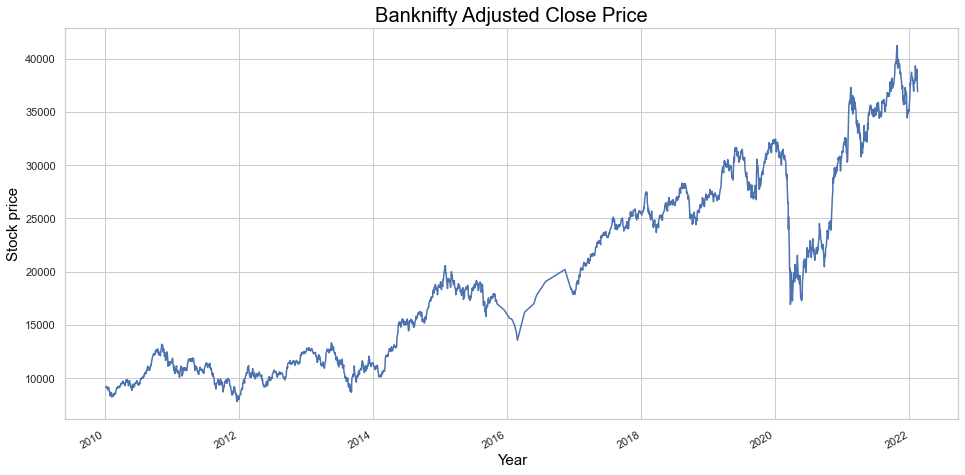

In [36]:
# Plot Adjusted Close price

bn['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize' : (16, 8)})
plt.title('Banknifty Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);


In [4]:
# Create DataFrame for Adjusted Close price

bn = bn[['Adj Close']]

In [5]:
bn

,Adj Close
Date,
2010-01-04,9112.349609
2010-01-05,9192.150391
2010-01-06,9223.000000
2010-01-07,9192.950195
2010-01-08,9160.700195
...,...
2022-02-08,38028.449219
2022-02-09,38610.250000
2022-02-10,39010.949219


## 4. Create training data set

In [8]:
# Convert DataFrame to numpy array
bn_arr = bn.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(bn))

training_data_len

2160

In [9]:
# Create train data set

train = bn_arr[0:training_data_len, :]

### Feature scaling
We will normalise the training data before model fitting by converting the values of numeric columns in the data set to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance.

In [10]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.0540116 ],
       [0.05729229],
       [0.05856055],
       ...,
       [0.9831445 ],
       [0.96787594],
       [0.96685226]])

In [11]:
train_scaled.shape

(2160, 1)

### Split training data into X_train, y_train

In [12]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
        print(X_train)
        print(y_train)
        print()

[array([0.0540116 , 0.05729229, 0.05856055, 0.05732517, 0.05599934,
       0.0565276 , 0.04878023, 0.04635468, 0.04572569, 0.04573802,
       0.0532264 , 0.0549798 , 0.05458716, 0.04607514, 0.04004623,
       0.03691971, 0.02184021, 0.02570669, 0.03506767, 0.03497312,
       0.02752794, 0.03425778, 0.02764918, 0.01745984, 0.02235   ,
       0.02441583, 0.020204  , 0.02396156, 0.02113723, 0.02463576,
       0.03095452, 0.03187543, 0.02830696, 0.0285639 , 0.0293697 ,
       0.02902435, 0.0303913 , 0.03799478, 0.04619024, 0.05101464,
       0.04996012, 0.05097353, 0.05539296, 0.05507435, 0.05429528,
       0.05707437, 0.05650091, 0.05290779, 0.05362518, 0.05713813,
       0.05976509, 0.06052565, 0.05707851, 0.05855645, 0.06247637,
       0.06814764, 0.07067183, 0.06872729, 0.06828739, 0.0702669 ])]
[array([0.07811292])]

[array([0.0540116 , 0.05729229, 0.05856055, 0.05732517, 0.05599934,
       0.0565276 , 0.04878023, 0.04635468, 0.04572569, 0.04573802,
       0.0532264 , 0.0549798 , 0.05

In [13]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2100, 60, 1)

### Create and train model
We will create and train a model with four recurrent layers each with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1, and the tanh activation function. Dropout will be used after each hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer then fitted on the training set for 200 epochs with a batch size of 64.

In [15]:
# Build model - LSTM with 50 neurons and 4 hidden layers  

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
33/33 [==============================] - 8s 83ms/step - loss: 0.0372
Epoch 2/200
33/33 [==============================] - 3s 78ms/step - loss: 0.0051
Epoch 3/200
33/33 [==============================] - 2s 75ms/step - loss: 0.0041
Epoch 4/200
33/33 [==============================] - 2s 76ms/step - loss: 0.0043
Epoch 5/200
33/33 [==============================] - 2s 74ms/step - loss: 0.0037
Epoch 6/200
33/33 [==============================] - 2s 73ms/step - loss: 0.0034
Epoch 7/200
33/33 [==============================] - 3s 76ms/step - loss: 0.0031
Epoch 8/200
33/33 [==============================] - 3s 77ms/step - loss: 0.0029
Epoch 9/200
33/33 [==============================] - 2s 75ms/step - loss: 0.0029
Epoch 10/200
33/33 [==============================] - 2s 72ms/step - loss: 0.0030
Epoch 11/200
33/33 [==============================] - 2s 72ms/step - loss: 0.0027
Epoch 12/200
33/33 [==============================] - 2s 72ms/step - loss: 0.0028
Epoch 13/200
33/33 [=====

33/33 [==============================] - 2s 73ms/step - loss: 0.0011
Epoch 102/200
33/33 [==============================] - 2s 74ms/step - loss: 0.0012
Epoch 103/200
33/33 [==============================] - 2s 73ms/step - loss: 0.0011
Epoch 104/200
33/33 [==============================] - 2s 73ms/step - loss: 0.0011
Epoch 105/200
33/33 [==============================] - 3s 77ms/step - loss: 0.0012
Epoch 106/200
33/33 [==============================] - 3s 83ms/step - loss: 0.0011
Epoch 107/200
33/33 [==============================] - 3s 82ms/step - loss: 0.0010
Epoch 108/200
33/33 [==============================] - 2s 75ms/step - loss: 0.0010
Epoch 109/200
33/33 [==============================] - 3s 78ms/step - loss: 0.0011
Epoch 110/200
33/33 [==============================] - 2s 75ms/step - loss: 0.0013
Epoch 111/200
33/33 [==============================] - 3s 83ms/step - loss: 0.0010
Epoch 112/200
33/33 [==============================] - 3s 84ms/step - loss: 0.0012
Epoch 113/200
33/3

33/33 [==============================] - 3s 81ms/step - loss: 8.0369e-04
Epoch 197/200
33/33 [==============================] - 3s 82ms/step - loss: 9.4302e-04
Epoch 198/200
33/33 [==============================] - 3s 83ms/step - loss: 8.0573e-04
Epoch 199/200
33/33 [==============================] - 3s 78ms/step - loss: 7.8053e-04
Epoch 200/200
33/33 [==============================] - 3s 79ms/step - loss: 8.8264e-04


### Create test set

In [16]:
test = bn_arr[training_data_len: , :]

In [17]:
test.shape

(541, 1)

In [18]:
# Predicting 253 values, using past 60 from the train data
inputs = bn_arr[len(bn_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [19]:
# Create data sets X_test and y_test
X_test = []
y_test = bn_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

In [20]:
# Convert data to numpy array
X_test = np.array(X_test)

In [21]:
# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
print(X_test.shape)

(541, 60, 1)


### Make Predictions using the test set

In [23]:
# We want predictions to contain same values as y_test data set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [24]:
predictions.shape

(541, 1)

### Calculate the RMSE using the actual values
RMSE is the standard deviation of the residuals and is a good measure of how accurately the model predicts the reponse. Lower values of RMSE indicate a better fit.

In [25]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

144.68134458756933

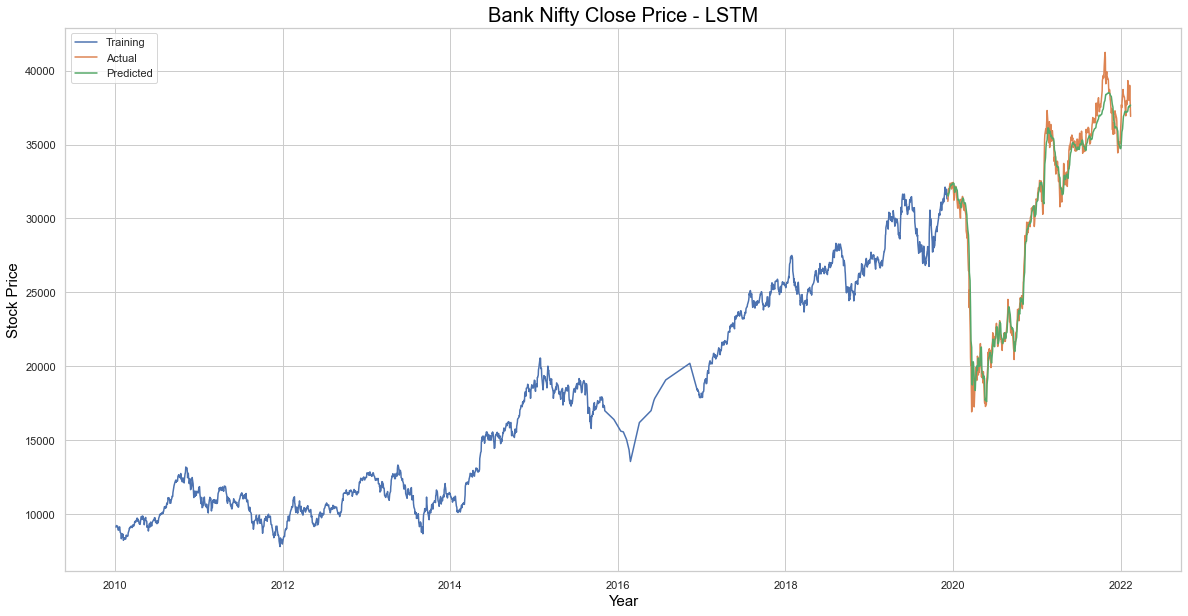

In [27]:
# Plot predicted vs actual values  
train = bn[:training_data_len]
test = bn[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Bank Nifty Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

## DataFrame of actual vs predicted prices plotted above

In [28]:
# Show the actual and predicted prices  

test

,Adj Close,Predictions
Date,,
2019-12-10,31160.349609,31704.130859
2019-12-11,31256.750000,31585.912109
2019-12-12,31665.449219,31524.244141
2019-12-13,32014.250000,31597.787109
2019-12-16,31974.199219,31765.111328
...,...,...
2022-02-08,38028.449219,37585.714844
2022-02-09,38610.250000,37550.503906
2022-02-10,39010.949219,37563.757812


### Predict Adjusted Close price for 15 Feb 2022

In [30]:
# Predict Adjusted Close price for AZN stock for 11 Jul 2019   
# get the quote
bn_quote = yf.download("^NSEBANK", start="2010-01-01", end="2022-02-15")
# Create new df
new_df = bn_quote.filter(['Adj Close'])
# Get last 60 days closing price and convert df to array])
last_60_days = new_df[-60:].values
# Scale data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create empty list
X_test = []
# Append last 60 days 
X_test.append(last_60_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
[[37584.887]]


### Actual Adjusted Close price for 15 Feb 2022

In [35]:
# Actual price
bn_quote2 = yf.download("^NSEBANK", start="2022-02-15", end="2022-02-16")
print(bn_quote2['Adj Close'])

[*********************100%***********************]  1 of 1 completed
Date
2022-02-15    38170.101562
Name: Adj Close, dtype: float64


The predicted Adjusted Close price for 15 Feb 2022 was 37584.88, lower than the actual price of 38170.10. Accuracy could be improved by trying different numbers of layers, epochs and batch sizes.